In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv('StackOverflow.csv')[['month', 'matlab']]
df['month'] = pd.to_datetime(df['month'], format='%y-%b')
df.set_index('month', inplace=True)
df.head()

,matlab
month,
2009-01-01,19
2009-02-01,27
2009-03-01,24
2009-04-01,32
2009-05-01,42


<Axes: xlabel='month'>

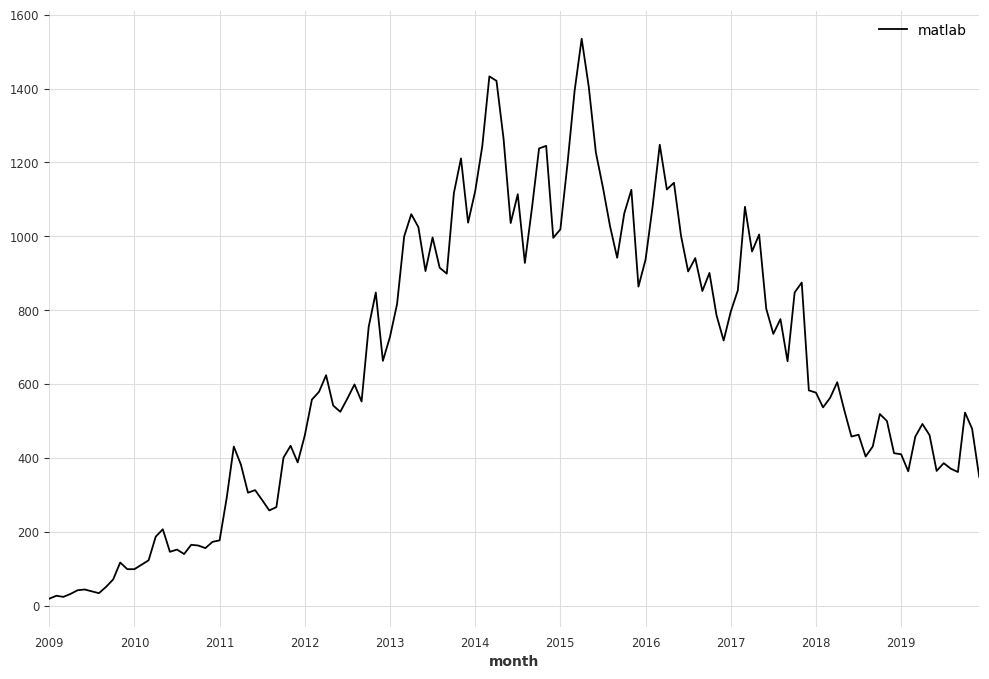

In [62]:
df.plot(legend=True,label='matlab',figsize=(12,8))

In [63]:
import seaborn as sns

Text(0.5, 0, '')

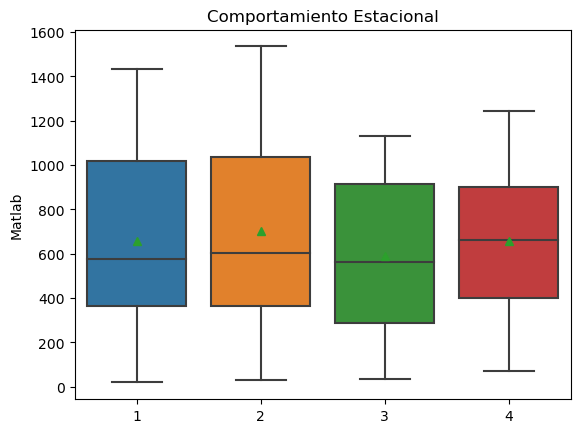

In [5]:
df['month'] = df.index.quarter

sns.boxplot(data=df, x='month', y='matlab',showmeans=True)
ax = plt.gca()
ax.set_ylabel('Matlab')
ax.set_title('Comportamiento Estacional')
ax.set_xlabel('')

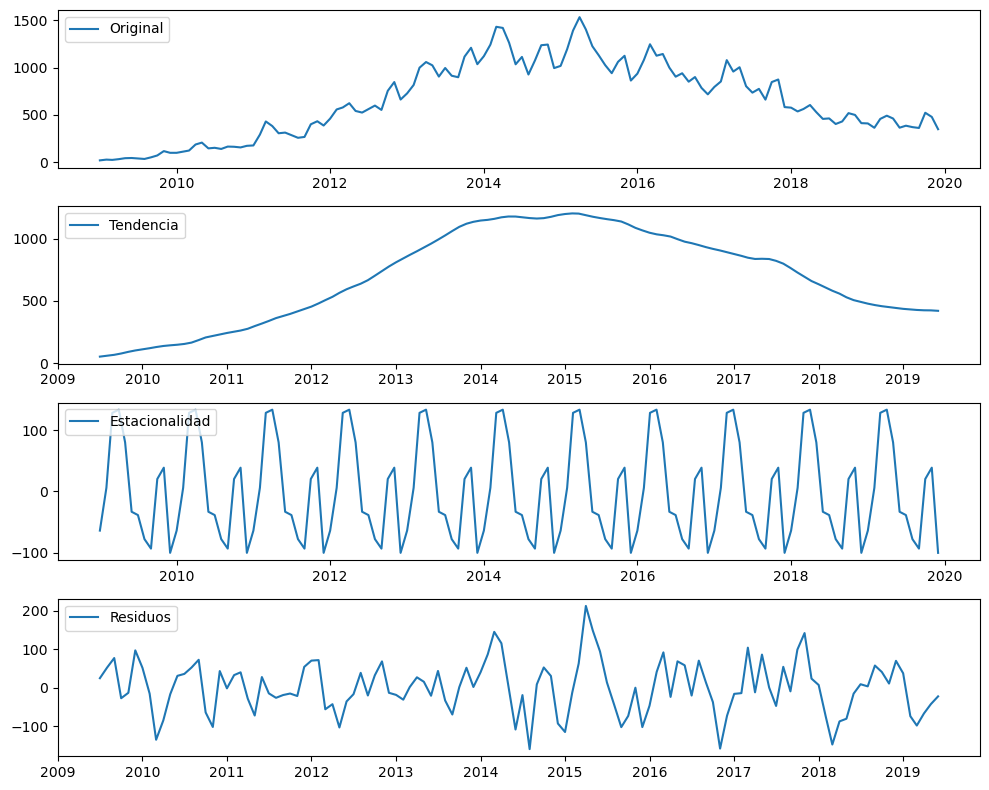

In [6]:
import statsmodels.api as sm


decomposition = sm.tsa.seasonal_decompose(df['matlab'], model='additive')

fig, axes = plt.subplots(4, 1, figsize=(10, 8))

axes[0].plot(df.index, decomposition.observed, label='Original')
axes[0].legend(loc='upper left')
axes[1].plot(df.index, decomposition.trend, label='Tendencia')
axes[1].legend(loc='upper left')
axes[2].plot(df.index, decomposition.seasonal, label='Estacionalidad')
axes[2].legend(loc='upper left')
axes[3].plot(df.index, decomposition.resid, label='Residuos')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [7]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train_0, y_test = temporal_train_test_split(y = df['matlab'].astype('float64').to_period('m'), test_size=6)
y_train_1, y_validation_1 = temporal_train_test_split(y = y_train_0.astype('float64'), test_size=12)

# ETS

In [8]:
from sktime.forecasting.ets import AutoETS

In [9]:
ets_model = AutoETS(auto=True, sp=12, n_jobs=-1)
ets_model.fit(y_train_0)
print(ets_model.summary())

                                 ETS Results                                  
Dep. Variable:                 matlab   No. Observations:                  126
Model:                       ETS(MAM)   Log Likelihood                -690.953
Date:                Tue, 07 Nov 2023   AIC                           1417.907
Time:                        12:44:01   BIC                           1468.960
Sample:                    01-31-2009   HQIC                          1438.648
                         - 06-30-2019   Scale                            0.015
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.107      9.376      0.000       0.791       1.209
smoothing_trend         0.0182      0.022      0.834      0.404      -0.025       0.061
smoothing_season

/Users/miguelsantis19/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
from sktime.utils.plotting import plot_series

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='matlab'>)

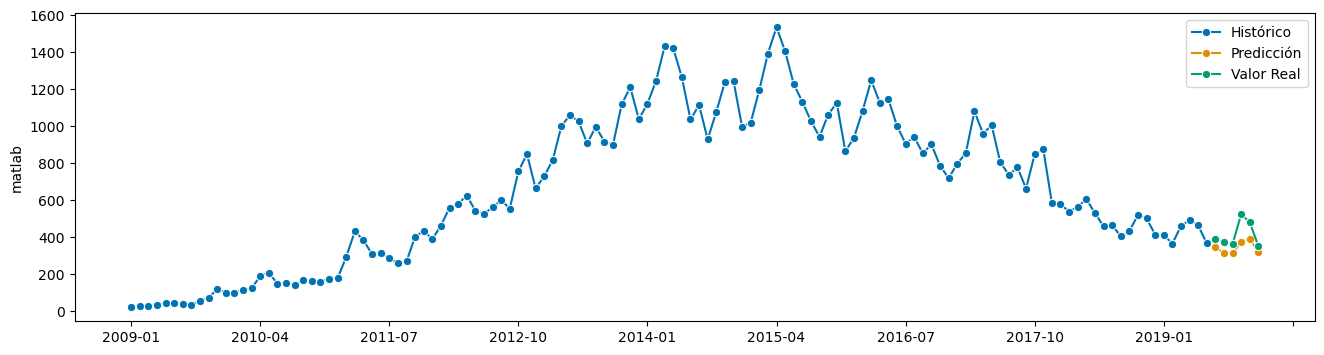

In [11]:
horizon = np.arange(1, 7)
ets_prediction = ets_model.predict(horizon)
ets_intervals = ets_model.predict_interval(horizon, coverage=0.9)
plot_series(y_train_0, ets_prediction, y_test, labels=["Histórico", "Predicción", "Valor Real"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='matlab'>)

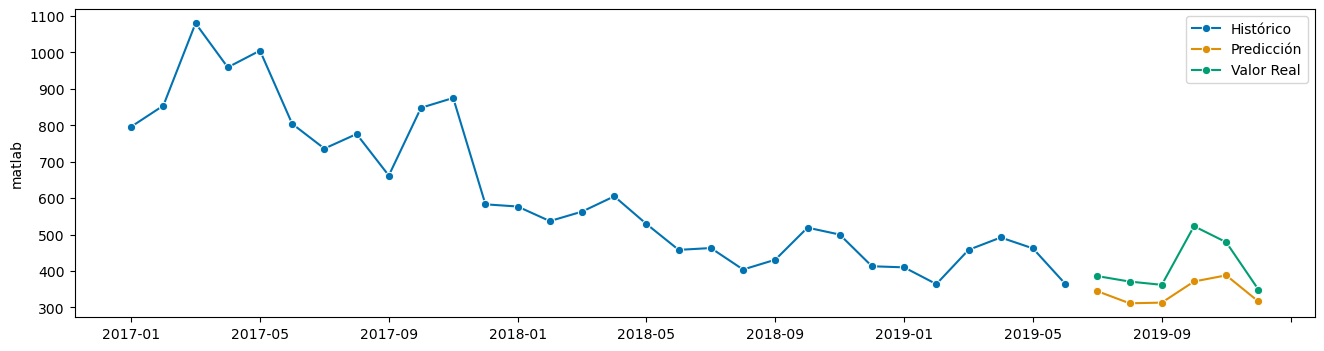

In [12]:
plot_series(y_train_0['2017':], ets_prediction, y_test, labels=["Histórico", "Predicción", "Valor Real"])

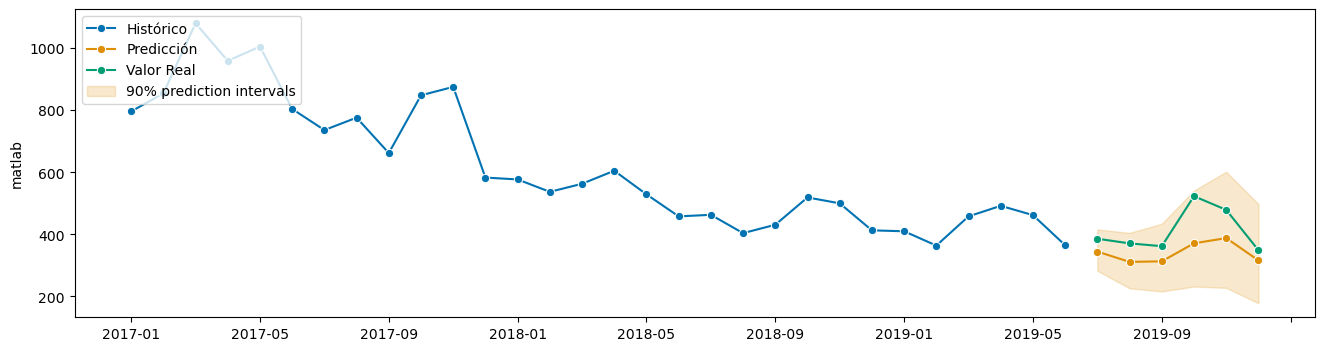

In [13]:
fig, ax = plot_series(y_train_0['2017':], ets_prediction, y_test, labels=["Histórico", "Predicción", "Valor Real"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    ets_intervals[('matlab', 0.9, 'lower')],
    ets_intervals[('matlab', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')


In [14]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# option 1: using the lean function interface

ets = mean_absolute_percentage_error(y_test, ets_prediction[0:8])
ets

0.16278756408015796

In [15]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, ets_prediction[0:8])

6673.546147936121

In [16]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, ets_prediction[0:8])

81.69177527717292

# ARIMA

In [17]:
from sktime.transformations.series.boxcox import LogTransformer

Text(0.5, 1.0, 'matlab con transformación logaritmica')

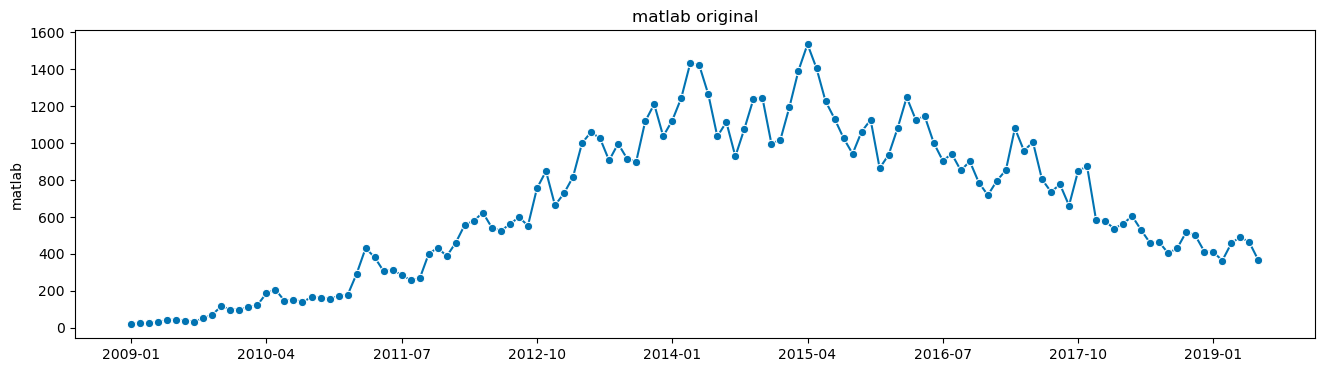

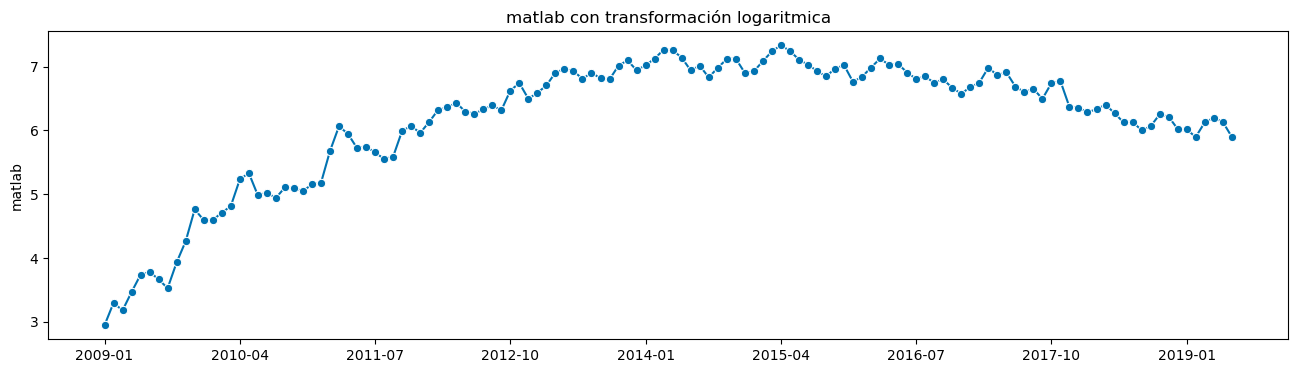

In [18]:
transformer = LogTransformer()
transformer = transformer.fit(y_train_0)
y_train_log = transformer.transform(y_train_0)
y_test_log = transformer.transform(y_test)


fig, ax =plot_series(y_train_0)
ax.set_title('matlab original')
fig, ax =plot_series(y_train_log)
ax.set_title('matlab con transformación logaritmica')

In [19]:
# Autocorrelation Fuction Package
from sktime.utils.plotting import plot_correlations

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='matlab'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

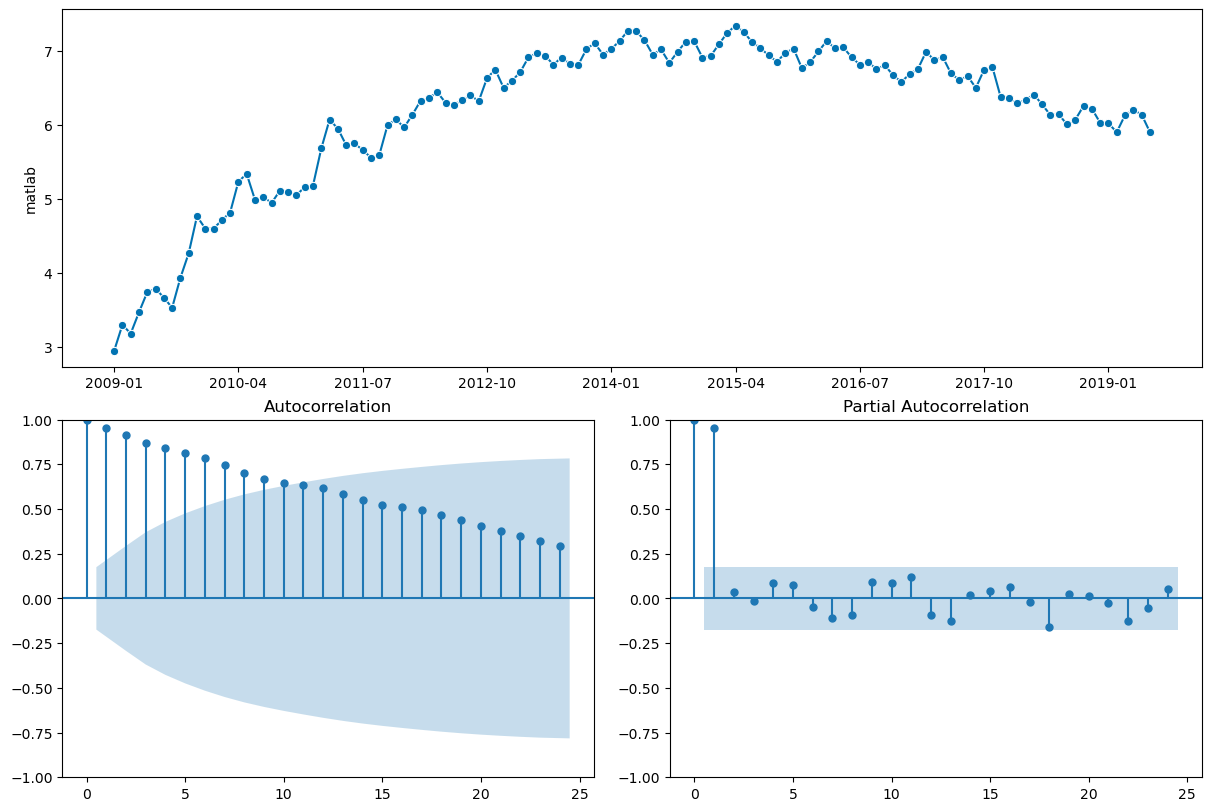

In [20]:
# Autocorrelation Fuction Original Time Series
plot_correlations(y_train_log)

In [21]:
# Difference Fuction Package
from sktime.transformations.series.difference import Differencer

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='matlab'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

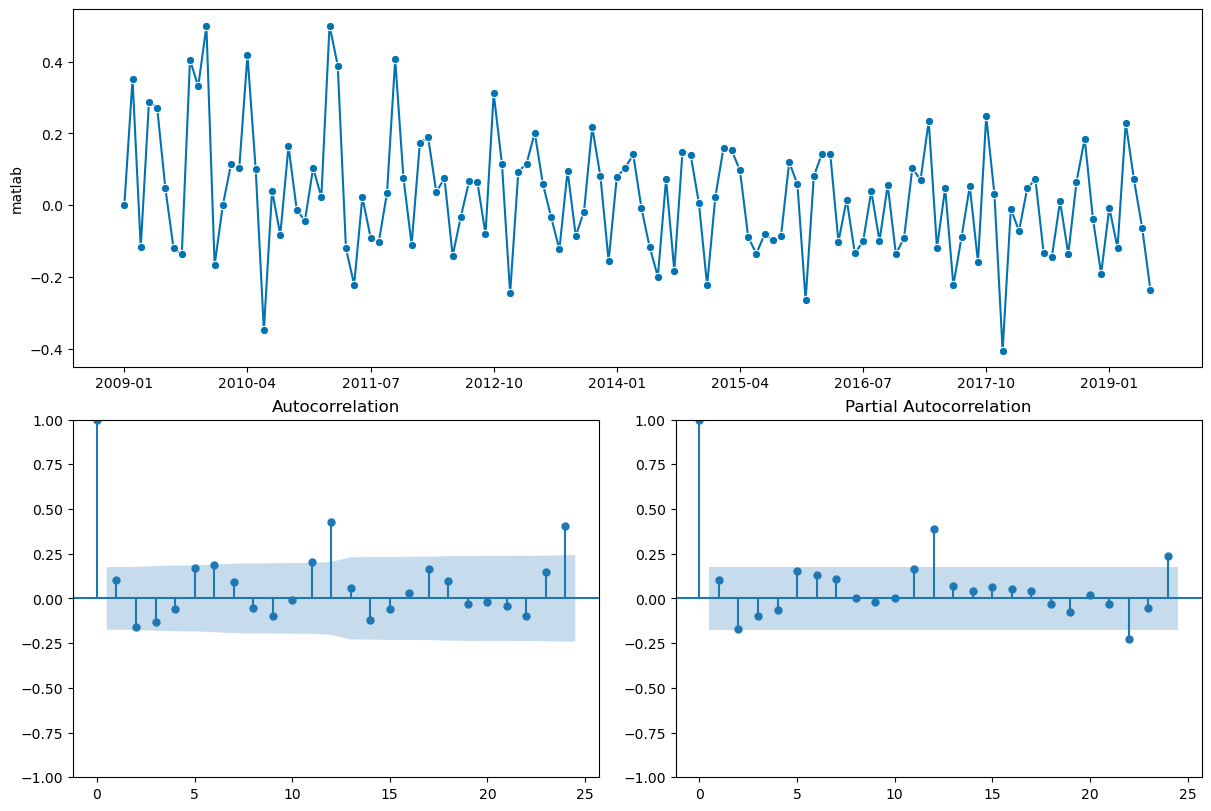

In [22]:
transf_diff=Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(y_train_log))

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='matlab'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

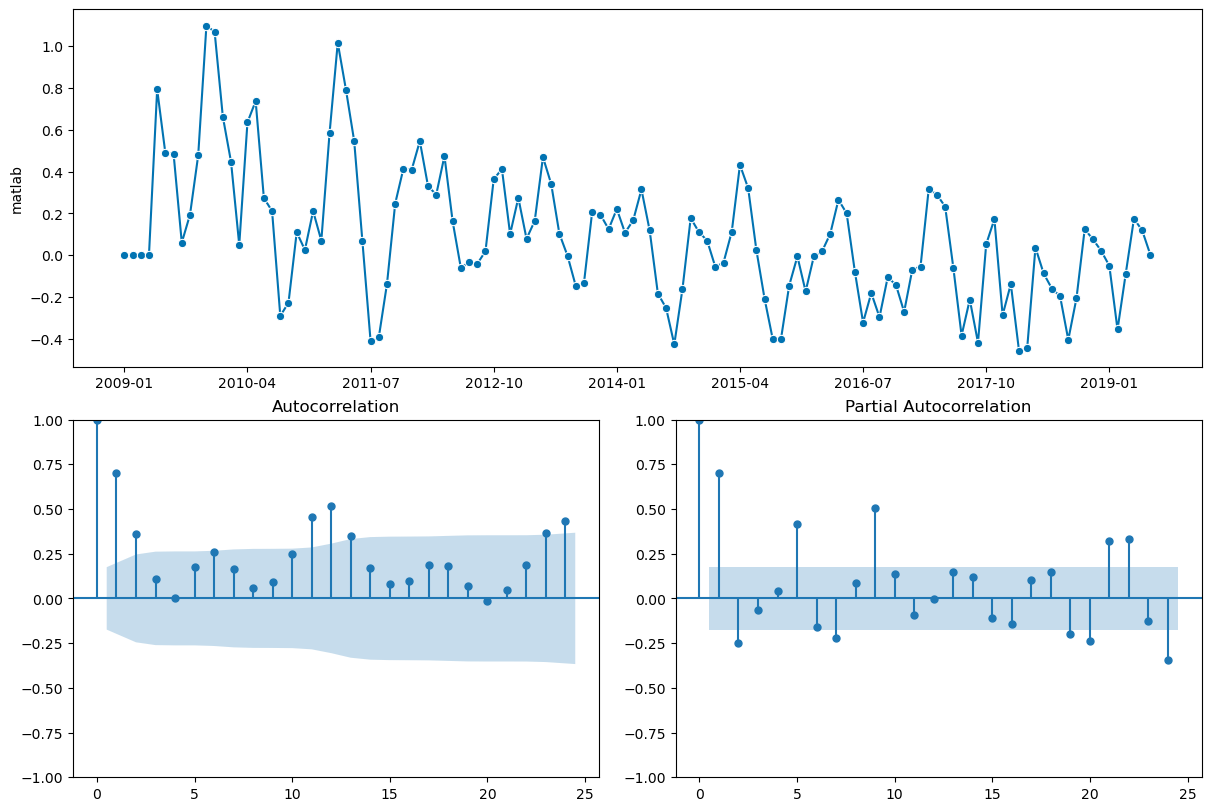

In [23]:
transf_diff=Differencer(lags=[4])
plot_correlations(transf_diff.fit_transform(y_train_log))

In [24]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA

In [25]:
arima_model = AutoARIMA(sp=12,suppress_warnings=True, trace=True)
arima_model.fit(y_train_log)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=-16.233, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12] intercept   : AIC=-45.976, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-18.177, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[12] intercept   : AIC=-29.167, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[12] intercept   : AIC=-51.909, Time=0.37 sec
 ARIMA(1,2,0)(2,0,1)[12] intercept   : AIC=-58.896, Time=1.06 sec
 ARIMA(1,2,0)(1,0,1)[12] intercept   : AIC=-60.627, Time=0.37 sec
 ARIMA(1,2,0)(0,0,1)[12] intercept   : AIC=-40.053, Time=0.17 sec
 ARIMA(1,2,0)(1,0,2)[12] intercept   : AIC=-58.910, Time=0.79 sec
 ARIMA(1,2,0)(0,0,2)[12] intercept   : AIC=-43.440, Time=0.33 sec
 ARIMA(1,2,0)(2,0,2)[12] intercept   : AIC=-56.693, Time=1.03 sec
 ARIMA(0,2,0)(1,0,1)[12] intercept   : AIC=-35.313, Time=0.23 sec
 ARIMA(2,2,0)(1,0,1)[12] intercept   : AI

AutoARIMA(sp=12, suppress_warnings=True, trace=True)

In [26]:
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  126
Model:             SARIMAX(4, 2, 1)x(1, 0, 1, 12)   Log Likelihood                  71.666
Date:                            Tue, 07 Nov 2023   AIC                           -127.332
Time:                                    12:46:10   BIC                           -104.770
Sample:                                01-31-2009   HQIC                          -118.167
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1666      0.087     -1.904      0.057      -0.338       0.005
ar.L2         -0.2627      0.077   

In [27]:
y_pred_log = arima_model.predict(horizon)
np.exp(y_pred_log)

2019-07    328.845279
2019-08    302.435701
2019-09    294.237525
2019-10    334.724436
2019-11    325.758169
2019-12    260.705868
Freq: M, Name: matlab, dtype: float64

In [28]:
# Forecast Accuracy
# MAPE
mean_absolute_percentage_error(y_test_log, y_pred_log)

0.04670054587851796

In [29]:
# Forecast Accuracy
# MAPE 
# Orignal Time Serie

arima = mean_absolute_percentage_error(y_test, np.exp(y_pred_log))
arima

0.2421619045601585

In [30]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test_log, y_pred_log)

0.30090691202999487

In [31]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test, np.exp(y_pred_log))

114.95367077160269

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='matlab'>)

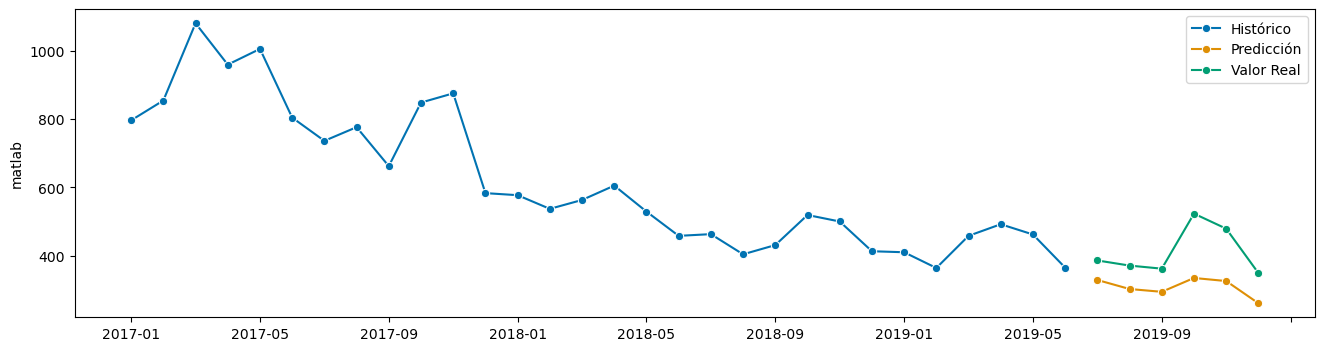

In [32]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(y_train_0['2017':], np.exp(y_pred_log),y_test, labels=["Histórico", "Predicción", "Valor Real"])

# 4Theta

In [33]:
from darts.models import Theta, FourTheta
from darts.metrics import mape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts import TimeSeries

In [38]:
df2 = df.copy()
df2.reset_index(level=0, inplace=True)

df_ts = TimeSeries.from_dataframe (df2,'month','matlab')
train, test = df_ts.split_before(pd.Timestamp("20190701"))

In [39]:
fourtheta1 =FourTheta(seasonality_period=12)
fourtheta1.fit(train)
prediccion_4theta = fourtheta1.predict(len(test))
print("model {} obtains MAPE: {:.2f}%".format(fourtheta1, mape(test, prediccion_4theta)))

model FourTheta(seasonality_period=12) obtains MAPE: 41.10%


Text(0.5, 1.0, '4Theta model')

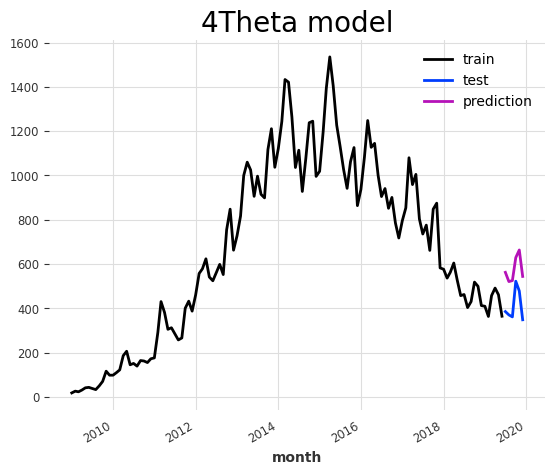

In [40]:
train.plot(label="train")
test.plot(label="test")
prediccion_4theta.plot(label="prediction")

plt.title(label="4Theta model",
          fontsize=20,
          color="black")

In [41]:
fourtheta_grid = {
    #'theta':2- np.linspace(-10, 10, 10),
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model=FourTheta.gridsearch(parameters=fourtheta_grid,
                                series=train,
                                forecast_horizon=36, # 12
                                start=0.5,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1)

best_grid_model

Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additiv

Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additiv

Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additive model
Negative Theta line. Fallback to additiv

(FourTheta(theta=1, seasonality_period=None, season_mode=SeasonalityMode.MULTIPLICATIVE, model_mode=ModelMode.ADDITIVE, trend_mode=TrendMode.EXPONENTIAL, normalization=True),
 {'theta': 1,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 44.399022105125766)

Text(0.5, 1.0, 'Best 4Theta model')

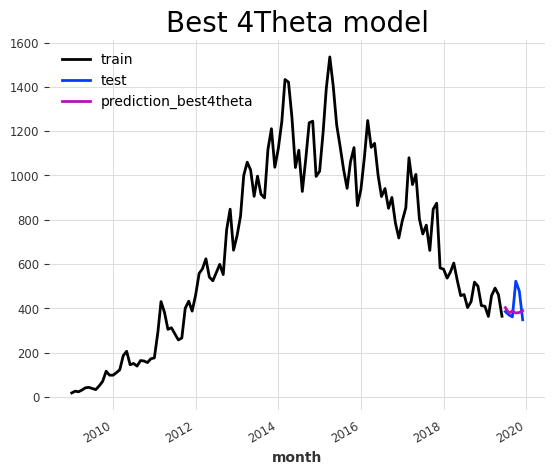

In [43]:
model_bestfourtheta=FourTheta(theta=best_grid_model[1]['theta'],
                 model_mode=ModelMode.ADDITIVE,
                 season_mode=SeasonalityMode.MULTIPLICATIVE,
                 trend_mode=TrendMode.LINEAR
                 )
model_bestfourtheta.fit(train)
prediction_best4theta = model_bestfourtheta.predict(len(test))

train.plot(label="train")
test.plot(label="test")
prediction_best4theta.plot(label="prediction_best4theta")

plt.title(label="Best 4Theta model",
          fontsize=20,
          color="black")

In [44]:
thetas = 2- np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0


for theta in thetas:

    model_4theta = Theta(theta)
    model_4theta.fit(train)
    prediction_4theta = model_4theta.predict(len(test))
    res = mape(test, prediction_4theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [45]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(test))

<Axes: xlabel='month'>

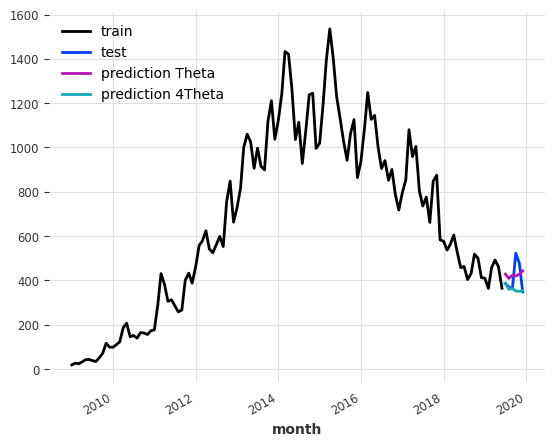

In [46]:
train.plot(label="train")
test.plot(label="test")
prediction_4theta.plot(label="prediction Theta")
pred_best_theta.plot(label="prediction 4Theta")

In [47]:
theta = mape(test,prediction_4theta)
theta

15.962246750884523

In [48]:
best4theta = mape (test, prediction_best4theta)
best4theta

12.279260550010425

# TBATS

In [49]:
from darts.models import TBATS

In [50]:
model_tbats =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods="freq",
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)
model_tbats.fit(train)
prediction_tbats = model_tbats.predict(len(test))

In [51]:
model_tbats.model.params.summary()

'Use Box-Cox: True\nUse trend: True\nUse damped trend: False\nSeasonal periods: [12.]\nSeasonal harmonics [4]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 0.575624\nSmoothing (Alpha): 0.731800\nTrend (Beta): 0.041770\nDamping Parameter (Phi): 1.000000\nSeasonal Parameters (Gamma): [ 1.31516020e-07 -3.15248939e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [ 3.62023513  1.87152987  1.10672604 -4.22303091 -1.89909995  0.80224378\n  4.20342617 -0.51672321  0.67266762  1.30258307]\n'

<Axes: xlabel='month'>

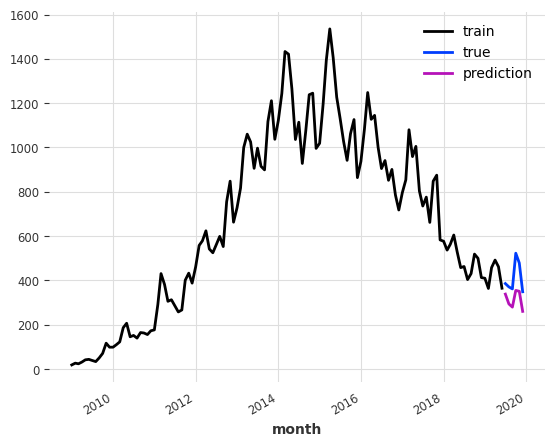

In [52]:
train.plot(label="train")
test.plot(label="true")
prediction_tbats.plot(label="prediction")

In [53]:
tbats = mape(test, prediction_tbats)
tbats

23.30709181640138

In [54]:
mape = pd.DataFrame()
mape['Nombre'] = ['ETS','ARIMA','4Theta','TBATS']
mape['MAPE'] = [ets,arima,theta,tbats]
mape.sort_values('MAPE')

,Nombre,MAPE
0,ETS,0.162788
1,ARIMA,0.242162
2,4Theta,15.962247
3,TBATS,23.307092


# Modelo Final

In [55]:
horizon = np.arange(12)
historic = df['matlab'].astype('float64').to_period('m')

/Users/miguelsantis19/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/miguelsantis19/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='matlab'>)

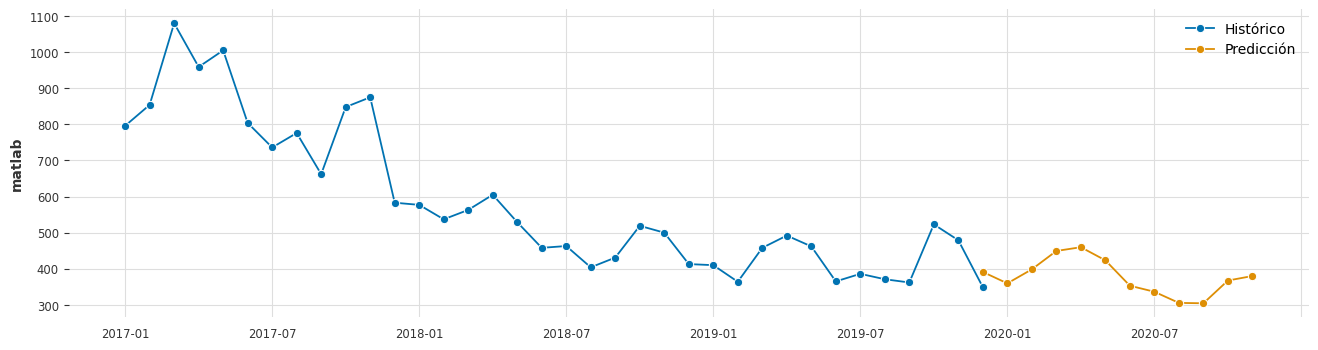

In [56]:
final_ets_model = AutoETS(auto=True, sp=12, n_jobs=-1)
final_ets_model.fit(historic)
ets_pred = final_ets_model.predict(horizon)
plot_series(historic['2017':], ets_pred, labels=["Histórico", "Predicción"])